In [1]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd
import gensim
import itertools
from tqdm.notebook import tqdm
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
from lapsolver import solve_dense
from numpy.linalg import norm
from numba import njit

pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline
tqdm.pandas()

c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('../data/2017/captions.csv')
print(len(df))
df.head()

3242


,coco_url,height,width,id,captions
0,http://images.cocodataset.org/val2017/00000039...,427,640,397133,rolling pots oven pies table standing near mad...
1,http://images.cocodataset.org/val2017/00000003...,230,352,37777,decorated ready small kitchen near clean see w...
2,http://images.cocodataset.org/val2017/00000025...,428,640,252219,past city walking dwellers walk standing next ...
3,http://images.cocodataset.org/val2017/00000008...,480,640,87038,skateboard tricks falls bike air performs skat...
4,http://images.cocodataset.org/val2017/00000017...,388,640,174482,fixture walk blue sidewalk locked next side ne...


In [5]:
limit = 100000
model = gensim.models.KeyedVectors.load_word2vec_format('../data/wiki.vec',
                                                       binary=False,
                                                       limit=limit)
model.init_sims(replace=True)

c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [9]:
vec_dict = np.zeros(shape=(5070, 300))
word_dict = {}
def caption_to_vec(text):
    vec = []
    for word in text.split():
        if word not in model:
            continue
        if word not in word_dict:
            idx = len(word_dict.keys())
            word_dict[word] = idx
            vec_dict[idx] = model[word]
        vec.append(word_dict[word])
    return np.array(vec, dtype=np.int)

df['captions_vec'] = df['captions'].progress_apply(lambda text: caption_to_vec(text))
print(f'There are {len(word_dict)} unique words')


There are 5070 unique words


In [10]:
df.head()

,coco_url,height,width,id,captions,captions_vec
0,http://images.cocodataset.org/val2017/00000039...,427,640,397133,rolling pots oven pies table standing near mad...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,http://images.cocodataset.org/val2017/00000003...,230,352,37777,decorated ready small kitchen near clean see w...,"[22, 23, 24, 15, 6, 25, 26, 27, 28, 29, 30, 4,..."
2,http://images.cocodataset.org/val2017/00000025...,428,640,252219,past city walking dwellers walk standing next ...,"[35, 36, 37, 38, 39, 5, 40, 41, 42, 43, 44, 45..."
3,http://images.cocodataset.org/val2017/00000008...,480,640,87038,skateboard tricks falls bike air performs skat...,"[51, 52, 53, 54, 55, 56, 57, 58, 18, 10, 59, 6..."
4,http://images.cocodataset.org/val2017/00000017...,388,640,174482,fixture walk blue sidewalk locked next side ne...,"[65, 39, 66, 67, 68, 40, 69, 6, 54, 70, 36, 71..."


In [11]:
@njit
def sigmoid(x):
    return 1 / (1 + 20*np.exp(-20*(x - 0.4)))

@njit
def create_pair_to_dist(vec_dict):
    W = vec_dict.shape[0]
    pair_to_dist = np.zeros(shape=(W, W), dtype=np.float32)
    for i in range(W):
        for j in range(i+1, W):
            u, v = vec_dict[i], vec_dict[j]
            # d = sigmoid(np.dot(u, v)/(norm(u)*norm(v)))
            d = np.dot(u, v)/(norm(u)*norm(v))
            pair_to_dist[i][j] = d
            pair_to_dist[j][i] = d
    return pair_to_dist

pair_to_dist = create_pair_to_dist(vec_dict)

In [12]:
np.save('pair_to_dist.npy', pair_to_dist)

In [13]:
url_to_vec = {}
for _, row in df.iterrows():
    url_to_vec[row['coco_url']] = row['captions_vec']

In [14]:
np.save('url_to_vec.npy', url_to_vec)

In [15]:
@njit(fastmath=True)
def calculate_dist_matrix(u, v, d):
    mat = np.zeros(shape=(u.shape[0], v.shape[0]), dtype=np.float32)
    for i in range(u.shape[0]):
        for j in range(v.shape[0]):
            a, b = u[i], v[j]
            mat[i][j] = pair_to_dist[a][b]
    return mat

def earthmover_score(u, v):
    dist_matrix = calculate_dist_matrix(u, v, pair_to_dist)
    assignment = solve_dense(dist_matrix)
    score = np.mean(dist_matrix[assignment])
    return score

def compute_scores(idx):
    init_caption_vec = df.iloc[idx]['captions_vec']
    f = lambda x: earthmover_score(init_caption_vec, x)
    scores = np.array(df['captions_vec'].progress_apply(f))
    return scores

def calculate_closest_idx(idx):
    initial_image_id = df.iloc[idx]['id']
    scores = compute_scores(idx)
    closest_idx = np.argsort(scores)
    print(scores[closest_idx])
    return closest_idx[1:]

In [16]:
annFile = '../data/2017/captions.json'
coco = COCO(annFile)

def show_image(image_id):
    imgIds = coco.getImgIds(imgIds = [image_id])
    img = coco.loadImgs(imgIds)[0]
    print(img['coco_url'])
    I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    plt.show()
    
def show_details(idx):
    row = df.iloc[idx]
    image_id = row['id']
    captions = list(set(row['captions'].split(' ')))
    show_image(image_id)
    print(captions)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [32]:
idx = 14
closest_idx = calculate_closest_idx(idx)


[0.         0.12757747 0.12821598 ... 0.30042303 0.30046976 0.30282527]


http://images.cocodataset.org/val2017/000000017627.jpg


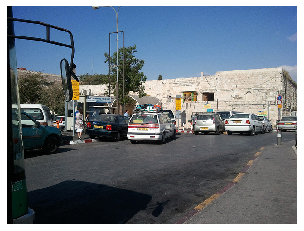

['lot', 'old', 'car', 'curb', 'front', 'parking', 'cars', 'parked', 'street', 'stone', 'several', 'building', 'near', 'green', 'small']


In [33]:
show_details(idx)

http://images.cocodataset.org/val2017/000000499181.jpg


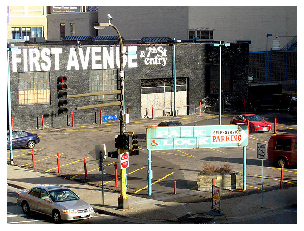

['street', 'avenue', 'many', 'first', 'parking', 'parked', 'black', 'building', 'entry', 'intersection', 'self', 'scene', 'service', '7th', 'lot', 'behind', 'cars', 'says', 'front']


In [34]:
show_details(closest_idx[0])

In [ ]:
with open('../../static/data/urls.txt', 'w') as f:
    for url in list(df['coco_url']):
        f.write(f'{url}\n')
f.close()